Team Number: 4  

Group Members:
1. BRENDAN EDWARD RAJ,  
2. CHUA ZONG HAN LIONEL,  
3. JASBIR KAUR,  
4. KOH YAO HAO,  
5. TIANG SOON LONG,  
6. TOH ZHEN WEI

---







# Section 1: Introduction

## 1.1 Problem Statement:

Accurately predicting football match outcomes has long been a challenge for analysts, bettors, and sports fans. Traditional prediction models rely on expert opinions, statistical trends, and historical performance, but these methods often fail to capture the complexity and dynamic nature of the game.

This project aims to explore the various machine learning models that predict football match outcomes based on historical match data, team statistics, and other relevant factors. By utilising modeling techniques, the objective is to enhance forecasting reliability and offer useful insights for analysts, teams, and even fans of the game.  



---



### 1.2 About the Dataset:
#### 1.2.1 Dataset 1
The match data dataset contains 5,778 rows and 127 columns, representing match data from the Premier League (2017-2024).   
Each row corresponds to an individual match played by a team, including detailed match statistics, opponent information, and season-wise records.

Sample Columns in the Dataset
- Match Details: Date, Round, Day, Season
- Team Performance: Venue, Result (W/D/L), Goals For, Goals Against, Opponent
- Possession & Passing: Possession %, Passes Attempted, Passes Completed, Progressive Passes
- Shooting & Goals: Shots, Shots on Target, Expected Goals (xG), Goals
- Defensive Actions: Tackles, Interceptions, Blocks, Clearances
- Dribbling & Carrying: Successful Take-Ons, Carries into Final Third, Progressive Carries

---

#### 1.2.2 Dataset 2
The FIFA Team Rating Dataset is sourced from the FIFA video game series, which assigns numerical ratings to teams based on their in-game squad attributes. These ratings are influenced by real-world player performances and are regularly updated by EA Sports through squad updates. These updates reflect player transfers, form changes, ensuring that the ratings stay aligned with real-world football dynamics. This indirectly helps us quantify areas of football that are hard to be represented as values.

The dataset includes several important attributes for each team:
- Overall Rating: A single score summarizing the team's overall strength.
- Attack Rating: A measure of offensive capabilities, including finishing, pace, and dribbling.
- Midfield Rating: Reflects playmaking, passing, and control in the midfield.
- Defense Rating: Evaluates defensive organization, tackling, and positioning.



---


URL Links to Data Sources:
1. https://sofifa.com/teams
2. https://fbref.com/en/comps/9/Premier-League-Stats


# Section 2: Project Set Up
In this section, we will import the relevant libraries and also load the scrapped data we manually collected

### 2.1 Import Libraries and Load Dataset

In [48]:
from datetime import timedelta
from itertools import cycle

import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

from sklearn.svm import SVC
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [49]:
df = pd.read_csv("2017-2024 match data.csv")

In [50]:
fifa_game_team_rating_df= pd.read_csv("fifa_team_rating.csv")

# Section 3: Data Cleaning
In this section, we will conduct data cleaning and explore our data.

### 3.1 Fix Mismatched Team and Opponent Names

From the website we scrapped our data from, we realised that they had given some of the teams with different names, even though it was the same 1 team.

For example:  
Brighton and Hove Albion vs Brighton  
Manchester United vs Manchester Utd


We will correct the names so that the data is standardised and every team only has one name.

In [51]:
team_names = set(df["Team"].unique())
opponent_names = set(df["Opponent"].unique())

only_in_team = sorted(team_names - opponent_names)
only_in_opponent = sorted(opponent_names - team_names)

print("Names in 'Team' but not in 'Opponent':", only_in_team)
print("Names in 'Opponent' but not in 'Team':", only_in_opponent)

Names in 'Team' but not in 'Opponent': ['Brighton and Hove Albion', 'Huddersfield Town', 'Manchester United', 'Newcastle United', 'Nottingham Forest', 'Sheffield United', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United', 'Wolverhampton Wanderers']
Names in 'Opponent' but not in 'Team': ['Brighton', 'Huddersfield', 'Manchester Utd', 'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd', 'Tottenham', 'West Brom', 'West Ham', 'Wolves']


In [52]:
team_name_corrections = {
    "Brighton and Hove Albion": "Brighton",
    "Huddersfield Town": "Huddersfield",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",
}

df["Team"] = df["Team"].replace(team_name_corrections)

### 3.2 Checking for Missing Data

In [53]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Attendance    882
SoT%            3
G/Sh            3
G/SoT         184
Dist            3
npxG/Sh         3
Save%         169
dtype: int64


### 3.3 Handling Missing Data for SoT%, G/Sh, Dist and npxG/sh
Next, we investigate the data to understand why there are exactly 3 records missing for the following categories:

1. SoT% (Shots on Target %) = Percentage of shots that are on target  
2. G/Sh = Goals per shot taken  
3. Dist = Average Shot Distance  
4. npxG/sh = Non-Penalty Expected Goals per shot

Upon analysing the data and why there were missing values, we are confident that the website we scrapped the data from had mistakenly left it blank instead of '0.0'.   

How we realised this:

As the team had taken 0 shots, it would be impossible to have SoT% (Shots on Target %) or G/SoT (Goals per Shot on Target) - you can't produce any shot related metrics if a team doesn't take any shots

Thus, we will update the missing values in SoT%, G/Sh, Dist and npxG/Sh with 0

In [54]:
df['SoT%'] = df['SoT%'].fillna(0.0)
df['G/Sh'] = df['G/Sh'].fillna(0.0)
df['Dist'] = df['Dist'].fillna(0.0)
df['npxG/Sh'] = df['npxG/Sh'].fillna(0.0)

### 3.4 Handling Missing Data for Save% and G/SoT
The remaining columns of data to clean regarding missing data were: G/SoT and Save%, with 184 and 169 missing data points respectively.  

Similar to the previous step, we realised that the website we scrapped the data from had mistakenly left G/SoT and Save% blank.

Fixes Made for Save%:  
1. Ensure Save% is 0.0 when no shots were faced  
2. Compute Save% when SoTA > 0

Fixes Made for G/SoT:
1. G/SoT = 0.0 when SoT == 0 (No shots on target → No goals from shots on target)

In [55]:
df.loc[(df['SoTA'] == 0) & (df['Saves'] == 0), 'Save%'] = 0.0
df.loc[df['Save%'].isnull() & (df['SoTA'] > 0), 'Save%'] = (df['Saves'] / df['SoTA']) * 100
df.loc[df['SoT'] == 0, 'G/SoT'] = 0.0

### 3.5 Handling Missing Data for Attendance
Attendance has 882 missing datapoints, which makes up about 15% of our dataset.

Upon analysis and some research,  
2020-2021 Premier League season, many games had no attendance due to COVID-19 restrictions  
The no-fan period in the Premier League due to COVID-19 was mainly from:  
March 2020 – May 2021 (End of 2019-20 season & full 2020-21 season)  

First, we will check if there is any missing attendance outside covid period

In [56]:
# Convert Date column to DateTime
df["Date"] = pd.to_datetime(df["Date"])

covid_start = pd.to_datetime("2020-03-01")
covid_end = pd.to_datetime("2021-05-31")

df[df['Attendance'].isnull() & ~((df['Date'] >= covid_start) & (df['Date'] <= covid_end))]

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Opp Formation,Referee,Sh,SoT,SoT%,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,np:G-xG,SoTA,Saves,Save%,CS,Total_Cmp,Total_Att,Total_Cmp%,Total_TotDist,Total_PrgDist,Short Pass Cmp,Short Pass Att,Short Pass Cmp%,Medium Pass Cmp,Medium Pass Att,Medium Pass Cmp%,Long Pass Cmp,Long Pass Att,Long Pass Cmp%,Ast,xAG,xA,KP,1/3,PPA,CrsPA,PrgP,Passes Attempted,Live-ball Passes,Dead-ball Passes,Passes from Free Kicks,Through Balls,Switches,Crosses,Throw-ins Taken,Corner Kicks,Inswinging Corner Kick,Outswinging Corner Kicks,Straight Corner Kicks,Passes Completed,Passes Offside,Passes Blocked_x,SCA,SCA (Live-ball Pass),SCA (Dead-ball Pass),SCA (Take-On),SCA (Shot),SCA (Fouls Drawn),SCA (Defensive Action),GCA,GCA (Live-ball Pass),GCA (Dead-ball Pass),GCA (Take-On),GCA (Shot),GCA (Fouls Drawn),GCA (Defensive Action),Tackles,Tackles Won,Tackles (Def 3rd),Tackles (Mid 3rd),Tackles (Att 3rd),Dribblers Tackled,Dribbles Challenged,% of Dribblers Tackled,Challenges Lost,Blocks,Shots Blocked,Passes Blocked_y,Interceptions,Tkl+Int,Clearances,Errors,Possession %,Touches,Touches (Def Pen),Touches (Def 3rd),Touches (Mid 3rd),Touches (Att 3rd),Touches (Att Pen),Touches (Live-Ball),Take-Ons Attempted,Successful Take-Ons,Successful Take-On %,Times Tackled During Take-On,Tackled During Take-On Percentage,Carries,Total Carrying Distance,Progressive Carrying Distance,Progressive Carries,Carries into Final Third,Carries into Penalty Area,Miscontrols,Dispossessed,Passes Received,Progressive Passes Rec,Season,Team
4027,2023-05-28,16:30,Premier League,Matchweek 38,Sun,Away,L,1.0,2.0,Aston Villa,1.4,2.8,59.0,NaN,Pascal Groß,4-4-2,4-2-3-1,David Coote,8.0,4.0,50.0,0.13,0.25,18.2,0.0,0,0,1.4,0.17,-0.4,-0.4,5.0,3.0,60.0,0.0,375.0,456.0,82.2,6458.0,2450.0,165.0,192.0,85.9,180.0,201.0,89.6,23.0,34.0,67.6,1.0,1.3,0.9,7.0,22.0,4.0,2.0,33.0,456.0,407.0,43.0,13.0,4.0,1.0,7.0,12.0,3.0,1.0,0.0,0.0,375.0,6.0,12.0,15.0,13.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,13.0,2.0,6.0,5.0,2.0,4.0,19.0,21.1,15.0,7.0,2.0,5.0,3.0,16,15.0,0.0,59.0,549.0,85.0,224.0,234.0,95.0,19.0,549.0,16.0,8.0,50.0,5.0,31.3,298.0,1563.0,818.0,19.0,6.0,9.0,18.0,9.0,365.0,33.0,2022-2023,Brighton
4065,2023-05-28,16:30,Premier League,Matchweek 38,Sun,Home,W,2.0,1.0,Brighton,2.8,1.4,41.0,NaN,John McGinn,4-2-3-1,4-4-2,David Coote,12.0,5.0,41.7,0.17,0.40,18.2,4.0,0,0,2.8,0.24,-0.8,-0.8,4.0,3.0,75.0,0.0,229.0,315.0,72.7,4236.0,1741.0,98.0,109.0,89.9,103.0,128.0,80.5,25.0,61.0,41.0,2.0,2.6,1.8,8.0,24.0,6.0,2.0,27.0,315.0,265.0,50.0,18.0,3.0,2.0,13.0,19.0,3.0,3.0,0.0,0.0,229.0,0.0,5.0,24.0,14.0,2.0,2.0,0.0,5.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,14.0,6.0,5.0,6.0,3.0,5.0,13.0,38.5,8.0,13.0,1.0,12.0,12.0,26,7.0,0.0,41.0,413.0,64.0,153.0,166.0,106.0,19.0,413.0,21.0,15.0,71.4,4.0,19.0,236.0,1400.0,766.0,20.0,18.0,5.0,13.0,9.0,226.0,26.0,2022-2023,Aston Villa


From our code, we realised that there is 1 match with missing attendance data (2 records related to the same match)  
We will update attendance for missing attendance for Aston Villa vs Brighton using another reliable data source

Source: https://www.skysports.com/football/aston-villa-vs-brighton-and-hove-albion/stats/465006#:~:text=Aston%20Villa%20vs%20Brighton%20and,Villa%20ParkAttendance%3A%2042%2C212

In [57]:
df.loc[[4027, 4065], 'Attendance'] = 42212

For the remaining data which is still missing (covid games), we will replace the missing attendance with the team's median for that dataset  
We chose to use the median instead of setting it to 0 as it would mislead the machine learning model to identify false patterns and introduce bias in predictions.

In [58]:
# Step 1: Compute median attendance for each team when playing at home
home_medians = df[df['Venue'] == 'Home'].groupby('Team')['Attendance'].median()

# Step 2: Fill missing attendance for home games using their own home median
df.loc[(df['Attendance'].isnull()) & (df['Venue'] == 'Home'), 'Attendance'] = df['Team'].map(home_medians)

# Step 3: Fill remaining missing attendance for away games using the opponent's median (opponent is the home team)
df.loc[(df['Attendance'].isnull()) & (df['Venue'] == 'Away'), 'Attendance'] = df['Opponent'].map(home_medians)

We do a final check if there are any missing data remaining in the dataset. Empty output meaning no missing data in the dataset left.

In [59]:
print(df.isnull().sum()[df.isnull().sum() > 0])

Series([], dtype: int64)


In [60]:
# Dropping columns which has no direct impact with outcome
df = df.drop(columns=['Captain', 'Formation', 'Opp Formation', 'Referee',"Time", "Day", "Comp", "Attendance"])

# Move 'Season' to index 4
cols = list(df.columns)
cols.insert(4, cols.pop(cols.index('Season')))
df = df[cols]

# Move 'Team' to the index 7
cols = list(df.columns)
cols.insert(7, cols.pop(cols.index('Team')))
df = df[cols]

### 3.6 FIFA Video Game Team Rating Dataset Cleaning

In [61]:
fifa_game_team_rating_df = fifa_game_team_rating_df[['Roster Date', 'Team Name', 'Overall Rating', 'Attack', 'Midfield', 'Defense']]
fifa_game_team_rating_df.head()

,Roster Date,Team Name,Overall Rating,Attack,Midfield,Defense
0,12/3/2025,Manchester City,85,85,85,83
1,12/3/2025,Liverpool,84,84,83,86
2,12/3/2025,Arsenal,83,81,85,81
3,12/3/2025,Aston Villa,81,82,80,80
4,12/3/2025,Chelsea,81,83,82,79


Cleaning the dataset by fixing mismatched team names, as team names will be the primary variable used to merge both datasets together

In [62]:
team_names = set(df["Team"].unique())
fifa_names = set(fifa_game_team_rating_df["Team Name"].unique())

only_in_team = sorted(team_names - fifa_names)
only_in_fifa = sorted(fifa_names - team_names)

print("Names in 'Team' but not in 'Fifa':", only_in_team)
print("Names in 'Fifa' but not in 'Team':", only_in_fifa)

Names in 'Team' but not in 'Fifa': ['Bournemouth', 'Brighton', 'Fulham', 'Huddersfield', 'Manchester Utd', 'Newcastle Utd', "Nott'ham Forest", 'Sheffield Utd', 'Tottenham', 'West Brom', 'West Ham', 'Wolves']
Names in 'Fifa' but not in 'Team': ['AFC Bournemouth', 'Brighton & Hove Albion', 'Fulham FC', 'Huddersfield Town', 'Hull City', 'Manchester United', 'Middlesbrough', 'Newcastle United', 'Nottingham Forest', 'Sheffield United', 'Sunderland', 'Tottenham Hotspur', 'West Bromwich Albion', 'West Ham United', 'Wolverhampton Wanderers']


In [63]:
fifa_team_name_corrections = {
    "AFC Bournemouth": "Bournemouth",
    "Brighton & Hove Albion": "Brighton",
    "Fulham FC": "Fulham",
    "Huddersfield Town": "Huddersfield",
    "Manchester United": "Manchester Utd",
    "Newcastle United": "Newcastle Utd",
    "Nottingham Forest": "Nott'ham Forest",
    "Sheffield United": "Sheffield Utd",
    "Tottenham Hotspur": "Tottenham",
    "West Bromwich Albion": "West Brom",
    "West Ham United": "West Ham",
    "Wolverhampton Wanderers": "Wolves",
}

fifa_game_team_rating_df["Team Name"] = fifa_game_team_rating_df["Team Name"].replace(fifa_team_name_corrections)

# Section 4: Exploratory Data Analysis (EDA)

### 4.1 Goal Distribution

Most matches have low goal counts, with 0, 1, or 2 goals being the most frequent.  
The distribution is right-skewed, meaning high-scoring matches are rare.

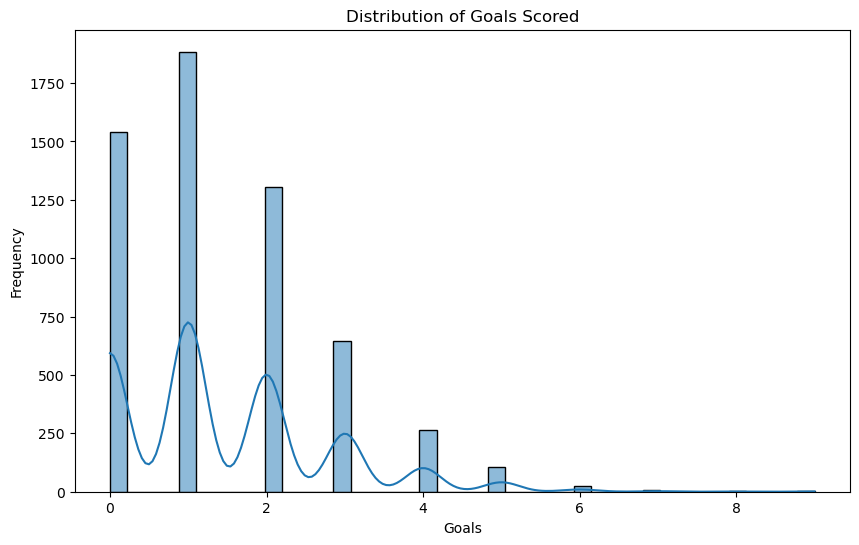

In [64]:
plt.figure(figsize=(10, 6))
sns.histplot(df['GF'], kde=True)
plt.title('Distribution of Goals Scored')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.show()

### 4.2 Match Result Distribution  
In this dataset there is much more wins/losses than draws.  
Thus predicting draws may be harder.

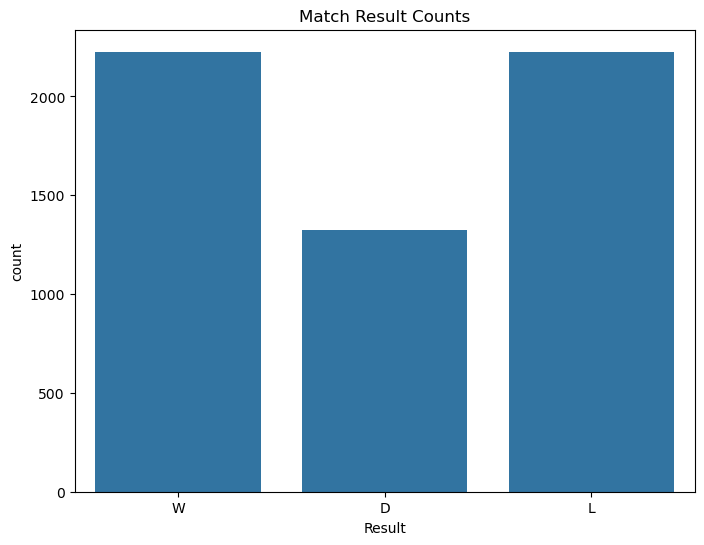

In [65]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Result', data=df)
plt.title('Match Result Counts')
plt.show()

### 4.3 Home vs. Away Performance:

Teams tend to perform better at home, with higher win counts compared to away games.  
Away matches have a higher frequency of losses, reinforcing the home advantage effect in football.

<Axes: xlabel='Venue', ylabel='count'>

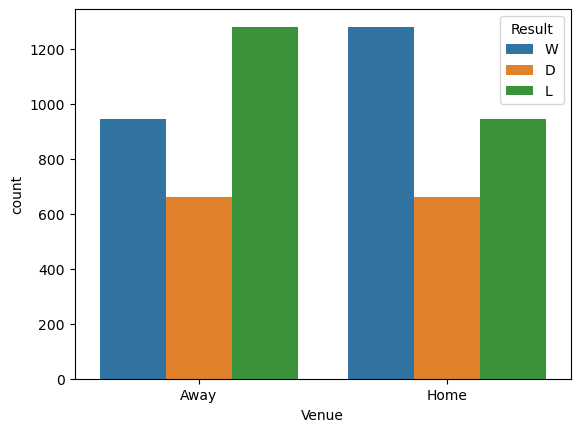

In [66]:
sns.countplot(x="Venue", hue="Result", data=df)

### 4.4 Feature Correlation

In machine learning, feature correlation analysis helps identify redundant or highly related variables to improve model efficiency and prevent overfitting.

When two features are 100% correlated, keeping both adds no additional value, so they can be removed.

Similarly, features with very high correlation (but not identical) often represent similar types of data, making one redundant (e.g., `"Live-ball Passes"` vs. `"Passes Received"`).

Additionally, domain knowledge plays a crucial role in feature selection, as some variables may have little to no impact on predicting football match outcomes (e.g., `"Throw-ins Taken"` and `"Corner Kick Types"`).

By systematically removing highly correlated and irrelevant features, the dataset is refined to include only unique and meaningful predictors, improving model interpretability and performance.

In [67]:
df_numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[df_numeric_cols].corr()

# Identify highly correlated features
threshold = 0.9
high_corr_features = []

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            high_corr_features.append((col1, col2, corr_matrix.iloc[i, j]))

# Display highly correlated features
print("\nHighly Correlated Feature Pairs (Threshold = {}):".format(threshold))
for col1, col2, corr_value in sorted(high_corr_features, key=lambda x: -abs(x[2])):
    print(f"{col1} ⟷ {col2} | Correlation: {corr_value:.2f}")


Highly Correlated Feature Pairs (Threshold = 0.9):
Passes Attempted ⟷ Total_Att | Correlation: 1.00
Passes Completed ⟷ Total_Cmp | Correlation: 1.00
Possession % ⟷ Poss | Correlation: 1.00
Touches (Live-Ball) ⟷ Touches | Correlation: 1.00
Passes Received ⟷ Total_Cmp | Correlation: 1.00
Passes Received ⟷ Passes Completed | Correlation: 1.00
Progressive Passes Rec ⟷ PrgP | Correlation: 1.00
Live-ball Passes ⟷ Total_Att | Correlation: 1.00
Live-ball Passes ⟷ Passes Attempted | Correlation: 1.00
Short Pass Att ⟷ Short Pass Cmp | Correlation: 1.00
Medium Pass Att ⟷ Medium Pass Cmp | Correlation: 0.99
Live-ball Passes ⟷ Total_Cmp | Correlation: 0.99
Passes Completed ⟷ Live-ball Passes | Correlation: 0.99
Passes Received ⟷ Live-ball Passes | Correlation: 0.99
Touches ⟷ Total_Att | Correlation: 0.99
Touches ⟷ Passes Attempted | Correlation: 0.99
Touches (Live-Ball) ⟷ Total_Att | Correlation: 0.99
Touches (Live-Ball) ⟷ Passes Attempted | Correlation: 0.99
Touches ⟷ Live-ball Passes | Correlati

In [68]:
# Drop columns that have the another column in the df that represents the exact same kind of data (100% correlation)
df = df.drop(columns=['Total_Att', 'Total_Cmp', 'Poss', 'Touches',"Passes Received", "PrgP"])

# Drop columns that have very high correlation to other columns in the DF/ represent very similar data
df = df.drop(columns=['np:G-xG',  'Long Pass Att', 'Medium Pass Att', 'Short Pass Att','Touches (Live-Ball)','Live-ball Passes','Dead-ball Passes','Progressive Carrying Distance','Progressive Carries','GCA','Total_TotDist','Take-Ons Attempted','Passes Blocked_x','Dribblers Tackled'])

# Drop columns based on domain knowledge that these columns have no direct relation to predicting outcome of football matches
df = df.drop(columns=['Switches','Throw-ins Taken','Outswinging Corner Kicks','Inswinging Corner Kick','Straight Corner Kicks', 'SCA','SCA (Live-ball Pass)','SCA (Dead-ball Pass)', 'SCA (Take-On)', 'SCA (Shot)', 'SCA (Fouls Drawn)', 'SCA (Defensive Action)',
                     'Touches (Def Pen)',	'Touches (Def 3rd)',	'Touches (Mid 3rd)','Tackles (Att 3rd)'])


# Section 5: Data and Feature Engineering

### 5.1 Data Engineering: Merging FIFA Game Team Ratings with Match Dataset

In [69]:
# Ensure Date columns are in datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
fifa_game_team_rating_df['Roster Date'] = pd.to_datetime(fifa_game_team_rating_df['Roster Date'], format='%d/%m/%Y')

# Sort data by date (VERY IMPORTANT for merge_asof)
df = df.sort_values(by='Date')
fifa_game_team_rating_df = fifa_game_team_rating_df.sort_values(by='Roster Date')

# Merge FIFA ratings for each team (backward to ensure no future data is leaked)
df = pd.merge_asof(
    df,
    fifa_game_team_rating_df,
    left_on='Date',
    right_on='Roster Date',
    left_by='Team',  # Match Team in df with Team Name in fifa_game_team_rating_df
    right_by='Team Name',
    direction='backward'  # Ensures only past data is used
)

# Rename merged columns for the Team
df = df.rename(columns={
    'Overall Rating': 'FIFA Overall Rating',
    'Attack': 'FIFA Attack Rating',
    'Midfield': 'FIFA Midfield Rating',
    'Defense': 'FIFA Defense Rating'
})

# Merge FIFA ratings for the Opponent (backward to prevent data leakage)
df = pd.merge_asof(
    df,
    fifa_game_team_rating_df,
    left_on='Date',
    right_on='Roster Date',
    left_by='Opponent',  # Match Opponent in df with Team Name in fifa_game_team_rating_df
    right_by='Team Name',
    direction='backward'  # Ensures only past data is used
)

# Rename merged columns for the Opponent
df = df.rename(columns={
    'Overall Rating': 'Opponent FIFA Overall Rating',
    'Attack': 'Opponent FIFA Attack Rating',
    'Midfield': 'Opponent FIFA Midfield Rating',
    'Defense': 'Opponent FIFA Defense Rating'
})

# Drop unnecessary columns
df = df.drop(columns=['Roster Date_x', 'Team Name_x','Roster Date_y', 'Team Name_y'])
df.head()

,Date,Round,Venue,Result,Season,GF,GA,Team,Opponent,xG,xGA,Sh,SoT,SoT%,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,SoTA,Saves,Save%,CS,Total_Cmp%,Total_PrgDist,Short Pass Cmp,Short Pass Cmp%,Medium Pass Cmp,Medium Pass Cmp%,Long Pass Cmp,Long Pass Cmp%,Ast,xAG,xA,KP,1/3,PPA,CrsPA,Passes Attempted,Passes from Free Kicks,Through Balls,Crosses,Corner Kicks,Passes Completed,Passes Offside,GCA (Live-ball Pass),GCA (Dead-ball Pass),GCA (Take-On),GCA (Shot),GCA (Fouls Drawn),GCA (Defensive Action),Tackles,Tackles Won,Tackles (Def 3rd),Tackles (Mid 3rd),Dribbles Challenged,% of Dribblers Tackled,Challenges Lost,Blocks,Shots Blocked,Passes Blocked_y,Interceptions,Tkl+Int,Clearances,Errors,Possession %,Touches (Att 3rd),Touches (Att Pen),Successful Take-Ons,Successful Take-On %,Times Tackled During Take-On,Tackled During Take-On Percentage,Carries,Total Carrying Distance,Carries into Final Third,Carries into Penalty Area,Miscontrols,Dispossessed,Progressive Passes Rec,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating
0,2017-08-11,Matchweek 1,Home,W,2017-2018,4.0,3.0,Arsenal,Leicester City,2.5,1.5,27.0,10.0,37.0,0.15,0.40,19.7,0.0,0,0,2.5,0.10,1.5,3.0,0.0,0.0,0.0,83.0,3216.0,276.0,88.7,214.0,88.1,58.0,66.7,4.0,2.5,1.7,25.0,55.0,15.0,3.0,681.0,15.0,2.0,20.0,9.0,565.0,5.0,5.0,1.0,0.0,2.0,0.0,0.0,23.0,17.0,12.0,9.0,16.0,68.8,5.0,6.0,0.0,6.0,13.0,36,33.0,1.0,68.0,252.0,30.0,16.0,84.2,3.0,15.8,519.0,3015.0,32.0,7.0,11.0,14.0,61.0,83,81,83,82,78,79,78,76
1,2017-08-11,Matchweek 1,Away,L,2017-2018,3.0,4.0,Leicester City,Arsenal,1.5,2.5,6.0,3.0,50.0,0.50,1.00,10.5,0.0,0,0,1.5,0.25,1.5,10.0,6.0,60.0,0.0,61.0,2006.0,90.0,81.1,51.0,63.8,37.0,41.1,3.0,1.4,1.2,4.0,19.0,4.0,3.0,315.0,14.0,2.0,18.0,4.0,192.0,3.0,3.0,1.0,0.0,1.0,0.0,0.0,17.0,8.0,11.0,4.0,19.0,15.8,16.0,18.0,8.0,10.0,11.0,28,29.0,0.0,32.0,120.0,11.0,5.0,31.3,11.0,68.8,150.0,942.0,7.0,2.0,10.0,12.0,16.0,78,79,78,76,83,81,83,82
2,2017-08-12,Matchweek 1,Away,W,2017-2018,2.0,0.0,Manchester City,Brighton,1.9,0.3,14.0,4.0,28.6,0.07,0.25,19.5,2.0,0,0,1.9,0.17,-0.9,2.0,2.0,100.0,1.0,87.6,3285.0,330.0,91.9,282.0,90.4,60.0,70.6,1.0,1.2,2.4,9.0,70.0,16.0,1.0,820.0,10.0,3.0,27.0,10.0,718.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,10.0,6.0,6.0,4.0,9.0,22.2,7.0,9.0,2.0,7.0,9.0,19,8.0,1.0,77.0,298.0,27.0,6.0,50.0,6.0,50.0,566.0,3154.0,26.0,3.0,14.0,4.0,87.0,83,83,85,81,72,72,73,73
3,2017-08-12,Matchweek 1,Away,W,2017-2018,3.0,2.0,Burnley,Chelsea,0.6,1.5,10.0,5.0,50.0,0.30,0.60,14.5,1.0,0,0,0.6,0.07,2.4,6.0,4.0,66.7,0.0,73.9,2521.0,59.0,73.8,137.0,86.7,61.0,61.0,3.0,0.4,0.6,8.0,22.0,7.0,4.0,348.0,16.0,0.0,16.0,5.0,257.0,1.0,4.0,1.0,1.0,0.0,0.0,0.0,8.0,4.0,6.0,2.0,8.0,37.5,5.0,13.0,7.0,6.0,13.0,21,44.0,0.0,38.0,74.0,11.0,2.0,66.7,1.0,33.3,190.0,942.0,12.0,1.0,10.0,9.0,25.0,74,74,74,76,83,86,84,81
4,2017-08-12,Matchweek 1,Away,D,2017-2018,3.0,3.0,Liverpool,Watford,2.6,2.1,13.0,4.0,30.8,0.15,0.50,13.9,0.0,1,1,1.8,0.14,0.4,4.0,1.0,25.0,0.0,73.2,2909.0,141.0,79.2,197.0,81.1,41.0,48.8,2.0,1.8,0.6,12.0,25.0,10.0,1.0,527.0,15.0,2.0,14.0,3.0,386.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,20.0,15.0,12.0,7.0,17.0,35.3,11.0,12.0,1.0,11.0,11.0,31,25.0,0.0,54.0,135.0,23.0,6.0,54.5,5.0,45.5,302.0,1860.0,16.0,4.0,16.0,14.0,40.0,81,82,81,81,77,78,78,76


Creating a copy of the cleaned df and assigning it as df_w_features so that it can be used for Feature Engineering

In [70]:
df_w_features= df.copy()

### 5.2 Feature: Home Advantage
Encoding home advantage as a binary variable (1 if the match is played at home, 0 otherwise).   

This feature can be useful for our classification model, as playing at home is often associated with higher chances of winning due to factors like crowd support, familiarity with the pitch, and reduced travel fatigue.

In [71]:
df_w_features['Venue_Home'] = (df_w_features['Venue'] == 'Home').astype(int)

### 5.3 Feature: Performance-Based Comparative Metrics
These features capture a team's dominance over its opponents in various aspects, such as goal difference, expected goals (xG), shots on target (SoT), and possession.

They provide insights into a team's attacking and defensive strengths. However, since they rely on match outcomes, using them directly for predictions could lead to data leakage. Instead, they will be used later on as rolling averages to reflect team trends over time without leaking future results.

In [72]:
def calculate_goal_difference(df):
    df["Goal_Diff"] = df["GF"] - df["GA"]
    return df

def calculate_xg_difference(df):
    df["xG_Difference"] = df["xG"] - df["xGA"]
    return df

def calculate_sot_difference(df):
    df["SoT_Difference"] = df["SoT"] - df["SoTA"]
    return df

def calculate_possession_difference(df):
    df["Opponent_Possession"] = 100 - df["Possession %"]
    df["Poss_Diff"] = df["Possession %"] - df["Opponent_Possession"]
    return df

### 5.4 Feature: Form-Based Features
These features quantify a team's recent performance by tracking past match results, points earned, and streaks. They include rolling average points over the last 5 matches, direct form comparisons with opponents, encoded past match sequences, and unbeaten streaks.

These metrics highlight a team's consistency and momentum, helping predict future performance trends. Since they rely on past results, they are structured to avoid data leakage by using only information available before each match.

Summary of functions:
1. `calculate_form_comparison(df)`  
  - Calculates: The difference in rolling average points (last 5 matches) between a team and its opponent.
  - Feature Value: Captures recent performance trends, helping assess which team has stronger momentum leading into the match.
2. `calculate_form_pattern(df, N=5)`
  - Calculates: A sequence of the team's last N match results (e.g., "WWLDW").
  - Feature Value: Provides historical performance context, helping detect winning/losing streaks or patterns.
  - Works with: `convert_form_pattern_to_numerical(df, N=5)` to transform categorical match sequences into numerical values.
3. `convert_form_pattern_to_numerical(df, N=5)`
  - Calculates: Converts the past N match results from `calculate_form_pattern()` into numerical values (Win = 1, Draw = 0, Loss = -1).
  - Feature Value: Transforms historical performance into a numeric format that machine learning models can interpret effectively.
4. `calculate_unbeaten_streak_before_match(df)`
  - Calculates: The number of consecutive matches a team has gone without losing before a match.
  - Feature Value: Highlights team consistency and resilience, indicating whether a team is on an unbeaten run or struggling.

5. `calculate_clean_sheet_percentage(df, N=5)`
  - Calculates: The percentage of clean sheets in the last N matches before a given match.
  - Feature Value: Captures short-term defensive consistency. Helps measure whether a team is in strong defensive form or struggling to keep clean sheets.

In [73]:
def calculate_form_comparison(df):
    df = df.sort_values(["Team", "Date"])
    df["Points_Earned"] = df["Result"].map({"W": 3, "D": 1, "L": 0})

    df["Team_Last_5_Avg_Points"] = df.groupby("Team")["Points_Earned"].shift(1).rolling(5).mean()

    # Merge with opponent's last 5 avg points
    df = df.merge(df[["Team", "Date", "Team_Last_5_Avg_Points"]],
                  left_on=["Opponent", "Date"],
                  right_on=["Team", "Date"],
                  suffixes=("", "_Opponent")).drop(columns=["Team_Opponent"], errors='ignore')

    df.rename(columns={"Team_Last_5_Avg_Points_Opponent": "Opponent_Last_5_Avg_Points"}, inplace=True)

    df["Last_5_Points_Comparison"] = df["Team_Last_5_Avg_Points"] - df["Opponent_Last_5_Avg_Points"]

    df.drop(columns=["Points_Earned"], inplace=True)

    return df

def calculate_form_pattern(df, N=5):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    form_patterns = []

    for team in df["Team"].unique():
        team_results = df[df["Team"] == team]["Result"].tolist()
        team_form = []

        for i in range(len(team_results)):
            if i == 0:
                team_form.append("")  # First match has no history
            else:
                # Extract last N results before current match
                start_idx = max(0, i - N)  # Ensure index doesn't go negative
                form_str = "".join(team_results[start_idx:i])  # Join past results into string
                team_form.append(form_str)

        form_patterns.extend(team_form)

    df["Form_Pattern_Before_Match"] = form_patterns

    return df

def convert_form_pattern_to_numerical(df, N=5):
    # Ensure column exists
    if "Form_Pattern_Before_Match" not in df.columns:
        print("Error: Form_Pattern_Before_Match column not found.")
        return df

    # Convert last N match results into separate numerical features
    for i in range(1, N+1):
        df[f"Form_{i}"] = df["Form_Pattern_Before_Match"].apply(lambda x: x[-i] if len(x) >= i else "None")

    # Map W/D/L to numerical values
    mapping = {"W": 1, "D": 0, "L": -1, "None": 0}
    for i in range(1, N+1):
        df[f"Form_{i}"] = df[f"Form_{i}"].map(mapping)

    df.drop(columns=["Form_Pattern_Before_Match"], inplace=True)

    return df

def calculate_unbeaten_streak_before_match(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    unbeaten_streak = []

    for team in df["Team"].unique():
        team_results = df[df["Team"] == team]["Result"].tolist()
        streak = 0
        team_streak = []

        for result in team_results:
            team_streak.append(streak)
            if result in ["W", "D"]:
                streak += 1
            else:
                streak = 0

        unbeaten_streak.extend(team_streak)

    df["Unbeaten_Streak_Before_Match"] = unbeaten_streak

    return df

def calculate_clean_sheet_percentage(df, N=5):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Date"])

    df["Last_5_Clean_Sheet_Percentage"] = (
        df.groupby("Team")["CS"]
        .apply(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
        .reset_index(drop=True)
    )

    return df

### 5.5 Feature: Season Performance Metrics
Understanding a team's long-term performance trends is crucial in predicting match outcomes. These features track a team's progress throughout the season by analyzing cumulative points, ranking, and comparative strength against opponents.  

By incorporating historical data, they provide insights into how consistently a team has performed and whether it is in good form or struggling. These metrics help identify title contenders, relegation risks, or mid-table teams and serve as a baseline for evaluating match expectations.

The following functions calculate seasonal performance indicators that ensure only past match data is considered, avoiding data leakage while providing useful context for predictive modeling.

Summary of functions:
1. `calculate_season_points(df)`
  - Calculates: Cumulative points earned before each match.
  - Feature Value: Represents a team's progress throughout the season.

2. `calculate_opponent_season_points(df)`
  - Calculates: The opponent’s cumulative season points before the match.
  - Feature Value: Helps compare team strength based on season-long performance.

3. `calculate_season_points_comparison(df)`
  - Calculates: The difference in season points before the match, between the team and its opponent.
  - Feature Value: Highlights the relative strength of both teams leading into the match.

4. `calculate_season_ranking(df)`
  - Calculates: Season ranking before each match, based on cumulative points.
  - Feature Value: Provides a dynamic measure of league standing and relative positioning.

5. `calculate_season_goal_difference(df)`
  - Calculates: A team's cumulative goal difference before each match in the season.
  - Feature Value: Reflects attacking and defensive efficiency over the season Also helps to assess whether a team has consistently outscored opponents or struggled defensively, and provides context on long-term performance rather than short-term fluctuations.

In [74]:
# Define a function to calculate season points earned before each match
def calculate_season_points(df):
    points_mapping = {"W": 3, "D": 1, "L": 0}

    df["Match_Points"] = df["Result"].map(points_mapping)
    df["Date"] = pd.to_datetime(df["Date"])

    df = df.sort_values(["Team", "Season", "Date"])
    df["Team_Season_Points_Before_Match"] = df.groupby(["Team", "Season"])["Match_Points"].cumsum().shift(1).fillna(0)
    df.loc[df["Round"] == "Matchweek 1", "Team_Season_Points_Before_Match"] = 0
    df.drop(columns=["Match_Points"], inplace=True)

    return df


def calculate_opponent_season_points(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Season", "Date"])

    df = df.merge(
        df[["Team", "Season", "Date", "Team_Season_Points_Before_Match"]],
        left_on=["Opponent", "Season", "Date"],
        right_on=["Team", "Season", "Date"],
        suffixes=("", "_Opponent")
    )

    df = df.rename(columns={"Team_Season_Points_Before_Match_Opponent": "Opponent_Season_Points_Before_Match"})
    df.drop(columns=["Team_Opponent"], errors='ignore', inplace=True)

    return df

def calculate_season_points_comparison(df):
    df["Season_Points_Comparison_Before_Match"] = df["Team_Season_Points_Before_Match"] - df["Opponent_Season_Points_Before_Match"]

    return df

def calculate_season_ranking(df):
    # Rank teams based on season points before each match (lower rank = higher position)
    df["Team_Season_Rank"] = df.groupby(["Season", "Date"])["Team_Season_Points_Before_Match"].rank(ascending=False, method="min")

    df = df.merge(df[["Team", "Season", "Date", "Team_Season_Rank"]],
                  left_on=["Opponent", "Season", "Date"],
                  right_on=["Team", "Season", "Date"],
                  suffixes=("", "_Opponent")).drop(columns=["Team_Opponent"], errors='ignore')

    df.rename(columns={"Team_Season_Rank_Opponent": "Opponent_Season_Rank"}, inplace=True)
    df["Rank_Comparison"] = df["Opponent_Season_Rank"] - df["Team_Season_Rank"]

    return df

def calculate_season_goal_difference(df):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Team", "Season", "Date"])

    # Compute cumulative goal difference per season for each team (before the match)
    df["Team_Goal_Difference_Before_Match"] = df.groupby(["Team", "Season"])["Goal_Diff"].cumsum().shift(1).fillna(0)

    df.loc[df["Round"] == "Matchweek 1", "Team_Goal_Difference_Before_Match"] = 0

    df = df.merge(
        df[["Team", "Season", "Date", "Team_Goal_Difference_Before_Match"]],
        left_on=["Opponent", "Season", "Date"],
        right_on=["Team", "Season", "Date"],
        suffixes=("", "_Opponent")
    )

    df.rename(columns={"Team_Goal_Difference_Before_Match_Opponent": "Opponent_Goal_Difference_Before_Match"}, inplace=True)
    df["Goal_Difference_Comparison_Before_Match"] = df["Team_Goal_Difference_Before_Match"] - df["Opponent_Goal_Difference_Before_Match"]
    df.drop(columns=["Team_Opponent"], errors='ignore', inplace=True)

    return df

### 5.6 Feature: Venue-Based Performance Trends
`calculate_home_away_performance(df, N=5)` measures how a team performs differently at home vs. away.

  - Calculates: Rolling average points per match at home vs. away.
  - Feature Value: Highlights a team's home advantage or away struggles.

Includes:
- `Home_Points_Per_Match` → Average points earned at home over last N games.
- `Away_Points_Per_Match` → Average points earned away over last N games.
- `Home_Away_Performance_Diff` → Difference between home & away performance.
- `Venue_Adjusted_Points_Per_Match` → Expected points based on venue.

In [75]:
def calculate_home_away_performance(df, N=5):
    df = df.sort_values(["Team", "Date"])
    df["Points_Earned"] = df["Result"].map({"W": 3, "D": 1, "L": 0})

    df["Home_Points_Earned"] = np.where(df["Venue"] == "Home", df["Points_Earned"], np.nan)
    df["Away_Points_Earned"] = np.where(df["Venue"] == "Away", df["Points_Earned"], np.nan)

    df["Home_Points_Per_Match"] = (
      df.groupby("Team")["Home_Points_Earned"]
      .transform(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
      .ffill()
      )

    df["Away_Points_Per_Match"] = (
        df.groupby("Team")["Away_Points_Earned"]
        .transform(lambda x: x.shift(1).rolling(N, min_periods=1).mean())
        .ffill()
    )

    df["Home_Away_Performance_Diff"] = df["Home_Points_Per_Match"] - df["Away_Points_Per_Match"]

    df["Venue_Adjusted_Points_Per_Match"] = np.where(
        df["Venue"] == "Home",
        df["Home_Points_Per_Match"],
        df["Away_Points_Per_Match"]
    )

    return df

### 5.7 Feature: Head-to-Head Performance Metrics
In football, past encounters between two teams can be a strong indicator of future match outcomes. Some teams consistently outperform others due to tactical advantages, psychological factors, or historical dominance. The Head-to-Head (H2H) Performance Metrics capture these trends by analyzing the most recent encounters between two teams. This information helps identify patterns such as a team having a winning streak over a specific opponent, a history of closely contested matches, or frequent draws.


`calculate_head_to_head_record(df, N=4)`
  - Calculates:
    - The number of wins, draws, and losses in the last N matches between two teams.
    - The total number of H2H matches played before the current game.
    - The win percentage against the opponent over the last N encounters.
  - Feature Value:
Identifies historical dominance or weakness against a specific opponent.
Highlights whether a team is on a winning streak or struggling in recent H2H meetings.

In [76]:
def calculate_head_to_head_record(df, N=4):
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values(["Date"])

    # Create a copy of the dataframe to hold the results
    result_df = df.copy()

    # Initialize H2H columns
    result_df["H2H_Wins"] = 0
    result_df["H2H_Draws"] = 0
    result_df["H2H_Losses"] = 0
    result_df["H2H_Total_Matches"] = 0
    result_df["H2H_Win_Percentage"] = 0.0

    # Process each match
    for idx, current_match in result_df.iterrows():
        team = current_match["Team"]
        opponent = current_match["Opponent"]
        match_date = current_match["Date"]

        historical_matches = df[
            (df["Date"] < match_date) &
            (df["Team"] == team) &
            (df["Opponent"] == opponent)
        ]

        last_n_matches = historical_matches.tail(N)

        if not last_n_matches.empty:
            h2h_wins = last_n_matches[last_n_matches["Result"] == "W"].shape[0]
            h2h_draws = last_n_matches[last_n_matches["Result"] == "D"].shape[0]
            h2h_losses = last_n_matches[last_n_matches["Result"] == "L"].shape[0]

            h2h_total = h2h_wins + h2h_draws + h2h_losses
            h2h_win_pct = h2h_wins / h2h_total if h2h_total > 0 else 0.0

            result_df.at[idx, "H2H_Wins"] = h2h_wins
            result_df.at[idx, "H2H_Draws"] = h2h_draws
            result_df.at[idx, "H2H_Losses"] = h2h_losses
            result_df.at[idx, "H2H_Total_Matches"] = h2h_total
            result_df.at[idx, "H2H_Win_Percentage"] = h2h_win_pct

    return result_df

### 5.8 Feature: FIFA Game Ratings
The FIFA Game Ratings feature leverages team ratings from the FIFA video game series, which assigns numerical ratings to teams based on their in-game attributes. These ratings reflect real-world player performances, team balance, and squad depth.

This feature extracts rating differences between a team and its opponent, highlighting disparities in overall squad strength, attacking power, midfield control, and defensive solidity. By incorporating these differences, models can assess whether a team has a significant advantage or disadvantage in key areas of the pitch.

`calculate_fifa_rating_diffs(df)`
- Calculates:
  - The overall rating difference between the team and its opponent.
  - The attack rating difference, which measures the disparity in offensive strength.
  - The midfield rating difference, reflecting control in playmaking and ball distribution.
  - The defense rating difference, indicating variations in defensive capabilities.
- Feature Value:
The FIFA rating differences quantify team strength disparities and serve as a predictive indicator of match outcomes. Higher positive values suggest a stronger team relative to its opponent, while negative values indicate a weaker squad.

In [77]:
def create_fifa_features(df):
    # Overall, Attack, Midfield, and Defense rating differences
    df['FIFA Overall Rating Diff'] = df['FIFA Overall Rating'] - df['Opponent FIFA Overall Rating']
    df['FIFA Attack Rating Diff'] = df['FIFA Attack Rating'] - df['Opponent FIFA Attack Rating']
    df['FIFA Midfield Rating Diff'] = df['FIFA Midfield Rating'] - df['Opponent FIFA Midfield Rating']
    df['FIFA Defense Rating Diff'] = df['FIFA Defense Rating'] - df['Opponent FIFA Defense Rating']

    return df

Apply functions of the features we engineered into the dataframe, and encoding the Target Variable ( the `Result` column) for Classification. This is necessary because most ML models only work with numerical data.

In [78]:
# Apply functions
df_w_features = calculate_goal_difference(df_w_features)
df_w_features = calculate_xg_difference(df_w_features)
df_w_features = calculate_sot_difference(df_w_features)
df_w_features = calculate_possession_difference(df_w_features)
df_w_features = calculate_form_comparison(df_w_features)
df_w_features = calculate_form_pattern(df_w_features)
df_w_features = convert_form_pattern_to_numerical(df_w_features)
df_w_features = calculate_unbeaten_streak_before_match(df_w_features)
df_w_features = calculate_season_points(df_w_features)
df_w_features = calculate_opponent_season_points(df_w_features)
df_w_features = calculate_season_points_comparison(df_w_features)
df_w_features = calculate_season_goal_difference(df_w_features)
df_w_features = calculate_head_to_head_record(df_w_features)
df_w_features = calculate_clean_sheet_percentage(df_w_features)
df_w_features = calculate_season_ranking(df_w_features)
df_w_features = calculate_home_away_performance(df_w_features)
df_w_features = create_fifa_features(df_w_features)

# Encode Target Variable
le = LabelEncoder()
df_w_features['Result'] = le.fit_transform(df_w_features['Result'])

df_w_features.tail()

,Date,Round,Venue,Result,Season,GF,GA,Team,Opponent,xG,xGA,Sh,SoT,SoT%,G/Sh,G/SoT,Dist,FK,PK,PKatt,npxG,npxG/Sh,G-xG,SoTA,Saves,Save%,CS,Total_Cmp%,Total_PrgDist,Short Pass Cmp,Short Pass Cmp%,Medium Pass Cmp,Medium Pass Cmp%,Long Pass Cmp,Long Pass Cmp%,Ast,xAG,xA,KP,1/3,PPA,CrsPA,Passes Attempted,Passes from Free Kicks,Through Balls,Crosses,Corner Kicks,Passes Completed,Passes Offside,GCA (Live-ball Pass),GCA (Dead-ball Pass),GCA (Take-On),GCA (Shot),GCA (Fouls Drawn),GCA (Defensive Action),Tackles,Tackles Won,Tackles (Def 3rd),Tackles (Mid 3rd),Dribbles Challenged,% of Dribblers Tackled,Challenges Lost,Blocks,Shots Blocked,Passes Blocked_y,Interceptions,Tkl+Int,Clearances,Errors,Possession %,Touches (Att 3rd),Touches (Att Pen),Successful Take-Ons,Successful Take-On %,Times Tackled During Take-On,Tackled During Take-On Percentage,Carries,Total Carrying Distance,Carries into Final Third,Carries into Penalty Area,Miscontrols,Dispossessed,Progressive Passes Rec,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating,Venue_Home,Goal_Diff,xG_Difference,SoT_Difference,Opponent_Possession,Poss_Diff,Team_Last_5_Avg_Points,Opponent_Last_5_Avg_Points,Last_5_Points_Comparison,Form_1,Form_2,Form_3,Form_4,Form_5,Unbeaten_Streak_Before_Match,Team_Season_Points_Before_Match,Opponent_Season_Points_Before_Match,Season_Points_Comparison_Before_Match,Team_Goal_Difference_Before_Match,Opponent_Goal_Difference_Before_Match,Goal_Difference_Comparison_Before_Match,H2H_Wins,H2H_Draws,H2H_Losses,H2H_Total_Matches,H2H_Win_Percentage,Last_5_Clean_Sheet_Percentage,Team_Season_Rank,Opponent_Season_Rank,Rank_Comparison,Points_Earned,Home_Points_Earned,Away_Points_Earned,Home_Points_Per_Match,Away_Points_Per_Match,Home_Away_Performance_Diff,Venue_Adjusted_Points_Per_Match,FIFA Overall Rating Diff,FIFA Attack Rating Diff,FIFA Midfield Rating Diff,FIFA Defense Rating Diff
5773,2024-12-29,Matchweek 19,Away,0,2024-2025,2.0,2.0,Wolves,Tottenham,0.7,2.2,11.0,3.0,27.3,0.18,0.67,20.0,1.0,0,0,0.7,0.07,1.3,3.0,0.0,33.3,0.0,78.4,1993.0,208.0,88.9,126.0,86.9,40.0,49.4,2.0,0.6,0.5,8.0,31.0,10.0,0.0,501.0,10.0,2.0,15.0,5.0,393.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,20.0,12.0,7.0,12.0,15.0,60.0,6.0,19.0,3.0,16.0,3.0,23,18.0,2.0,52.0,158.0,20.0,5.0,31.3,7.0,43.8,361.0,1650.0,14.0,3.0,15.0,11.0,37.0,77,76,76,77,81,81,81,79,0,0.0,-1.5,0.0,48.0,4.0,1.2,0.6,0.6,1,1,-1,-1,-1,2,15.0,23.0,-8.0,-11.0,13.0,-24.0,3,0,1,4,0.75,0.4,10.0,6.0,-4.0,1,NaN,1.0,1.5,1.000000,0.500000,1.000000,-4,-5,-5,-2
5774,2025-01-06,Matchweek 20,Home,1,2024-2025,0.0,3.0,Wolves,Nott'ham Forest,1.5,2.1,13.0,5.0,38.5,0.00,0.00,15.3,0.0,0,0,1.5,0.12,-1.5,3.0,0.0,0.0,0.0,81.8,2942.0,190.0,85.2,260.0,88.1,39.0,56.5,0.0,0.7,1.0,9.0,50.0,16.0,5.0,600.0,11.0,2.0,30.0,5.0,491.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,6.0,5.0,5.0,11.0,63.6,4.0,8.0,2.0,6.0,10.0,23,24.0,1.0,60.0,212.0,32.0,4.0,28.6,9.0,64.3,372.0,2438.0,18.0,6.0,13.0,9.0,67.0,77,76,76,77,77,77,77,78,1,-3.0,-0.6,2.0,40.0,20.0,1.4,3.0,-1.6,0,1,1,-1,-1,3,16.0,37.0,-21.0,-11.0,7.0,-18.0,0,4,0,4,0.00,0.4,2.0,1.0,-1.0,0,0.0,NaN,1.5,1.333333,0.166667,1.500000,0,-1,-1,-1
5775,2025-01-15,Matchweek 21,Away,1,2024-2025,0.0,3.0,Wolves,Newcastle Utd,1.6,2.1,13.0,7.0,53.8,0.00,0.00,17.4,0.0,0,0,1.6,0.12,-1.6,5.0,2.0,40.0,0.0,77.7,2182.0,139.0,86.9,133.0,87.5,40.0,53.3,0.0,1.5,0.7,12.0,31.0,13.0,4.0,413.0,13.0,2.0,10.0,2.0,321.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,8.0,16.0,7.0,22.0,27.3,16.0,18.0,6.0,12.0,10.0,35,13.0,0.0,40.0,129.0,22.0,9.0,42.9,8.0,38.1,292.0,1657.0,9.0,5.0,23.0,6.0,31.0,76,77,76,76,80,80,84,79,0,-3.0,-0.5,2.0,60.0,-20.0,1.4,3.0,-1.6,-1,0,1,1,-1,0,16.0,35.0,-19.0,-14.0,12.0,-26.0,0,1,3,4,0.00,0.4,7.0,2.0,-5.0,0,NaN,0.0,1.0,2.000000,-1.000000,2.000000,-4,-3,-8,-3
5776,2025-01-20,Matchweek 22,Away,1,2024-2025,1.0,3.0,Wolves,Chelsea,0.8,3.1,9.0,4.0,44.4,0.11,0.25,16.7,0.0,0,0,0.8,0.09,0.2,6.0,3.0,50.0,0.0,75.9,1590.0,153.0,92.7,

## 5.9 Feature: Calculating the Rolling Averages of in game statistics.
Selecting numeric features from `df_w_features` to apply rolling averages, as rolling averages can’t be applied to categorical/text features.  

The second line of code removes certain features from the rolling averages calculation.
Features like `"Result"`, `"Venue_Home"`, and "`H2H_Wins"` are excluded because:
- Some are categorical (e.g., `"Result"`, `"Venue_Home"`).
- Others are already rolling averages (e.g., `"Last_5_Avg_Points"`).
- Some are pre-calculated metrics that don’t require further smoothing (e.g., `"Rank_Comparsion"`).

Rolling averages help smooth out variations and prevent data leakage by ensuring that only historical data is used for predictions.

In [79]:
# Select numeric columns only as rolling averages can only be done on numeric columns
df_w_features_numeric_cols = df_w_features.select_dtypes(include=np.number).columns

# Specify the features that will have the rolling average function applied to them by dropping the features that do not need rolling averages
rolling_features = df_w_features_numeric_cols.drop(['Result', 'Venue_Home', 'FIFA Overall Rating', 'FIFA Attack Rating','FIFA Midfield Rating', 'FIFA Defense Rating', 'Opponent FIFA Overall Rating','Opponent FIFA Attack Rating','Opponent FIFA Midfield Rating','Opponent FIFA Defense Rating',
                                                    "FIFA Overall Rating Diff", "FIFA Attack Rating Diff", "FIFA Midfield Rating Diff", "FIFA Defense Rating Diff",
                                                    'Team_Last_5_Avg_Points',	'Opponent_Last_5_Avg_Points',	'Last_5_Points_Comparison', 'Form_1', 'Form_2', 'Form_3', 'Form_4', 'Form_5', 'Unbeaten_Streak_Before_Match',	'Team_Season_Points_Before_Match',	'Opponent_Season_Points_Before_Match',
                                                    'Season_Points_Comparison_Before_Match',	'Team_Goal_Difference_Before_Match',	'Opponent_Goal_Difference_Before_Match',	'Goal_Difference_Comparison_Before_Match',	'H2H_Wins',	'H2H_Draws',
                                                    'H2H_Losses',	'H2H_Total_Matches',	'H2H_Win_Percentage',	'Last_5_Clean_Sheet_Percentage',	'Team_Season_Rank',	'Opponent_Season_Rank',	'Rank_Comparison', 'Points_Earned',	'Home_Points_Earned',
                                                    'Away_Points_Earned',	'Home_Points_Per_Match',	'Away_Points_Per_Match',	'Home_Away_Performance_Diff',	'Venue_Adjusted_Points_Per_Match'], errors='ignore')

In [80]:
def rolling_averages(group, cols, new_cols):
    group = group.sort_values("Date")
    rolling_stats = group[cols].rolling(5, closed='left').mean()
    group[new_cols] = rolling_stats
    group = group.dropna(subset=new_cols)
    return group

In [81]:
# Use the previously specified columns (rolling_features) to have Rolling Average function applied and set a standard name format for the new columns created
cols = list(rolling_features)
new_cols = [f"{c}_Rolling_Avg" for c in cols]

In [82]:
# Apply Rolling Average Function
df_w_rolling_features = df_w_features.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))
df_w_rolling_features = df_w_rolling_features.droplevel('Team')

# Reset Index
df_w_rolling_features.index = range(df_w_rolling_features.shape[0])

# Drop all rows with NaN for Last_5_Avg_Points_Opponent, due to newly promoted teams with no history
df_w_rolling_features = df_w_rolling_features.dropna(subset=["Opponent_Last_5_Avg_Points"]).reset_index(drop=True)

# Create DF to specify columns that we are not allowed to use, to prevent data leakage
invalid_cols = df_w_features.columns[1:83].tolist()

# Keep 'Result' (index 3)
invalid_cols = [col for col in invalid_cols if col not in [df_w_features.columns[3]]]

#
invalid_cols.extend([df_w_features.columns[92],df_w_features.columns[93],df_w_features.columns[94],df_w_features.columns[95],
                     df_w_features.columns[96],df_w_features.columns[121],df_w_features.columns[122],df_w_features.columns[123]])

# Drop the invalid columns
df_w_rolling_features = df_w_rolling_features.drop(columns=invalid_cols, axis=1)

pd.set_option("display.max_columns", None)
df_w_rolling_features.head(10)

C:\Users\User\AppData\Local\Temp\ipykernel_69384\1062247026.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_w_rolling_features = df_w_features.groupby("Team").apply(lambda x: rolling_averages(x, cols, new_cols))


,Date,Result,FIFA Overall Rating,FIFA Attack Rating,FIFA Midfield Rating,FIFA Defense Rating,Opponent FIFA Overall Rating,Opponent FIFA Attack Rating,Opponent FIFA Midfield Rating,Opponent FIFA Defense Rating,Venue_Home,Team_Last_5_Avg_Points,Opponent_Last_5_Avg_Points,Last_5_Points_Comparison,Form_1,Form_2,Form_3,Form_4,Form_5,Unbeaten_Streak_Before_Match,Team_Season_Points_Before_Match,Opponent_Season_Points_Before_Match,Season_Points_Comparison_Before_Match,Team_Goal_Difference_Before_Match,Opponent_Goal_Difference_Before_Match,Goal_Difference_Comparison_Before_Match,H2H_Wins,H2H_Draws,H2H_Losses,H2H_Total_Matches,H2H_Win_Percentage,Last_5_Clean_Sheet_Percentage,Team_Season_Rank,Opponent_Season_Rank,Rank_Comparison,Home_Points_Per_Match,Away_Points_Per_Match,Home_Away_Performance_Diff,Venue_Adjusted_Points_Per_Match,FIFA Overall Rating Diff,FIFA Attack Rating Diff,FIFA Midfield Rating Diff,FIFA Defense Rating Diff,GF_Rolling_Avg,GA_Rolling_Avg,xG_Rolling_Avg,xGA_Rolling_Avg,Sh_Rolling_Avg,SoT_Rolling_Avg,SoT%_Rolling_Avg,G/Sh_Rolling_Avg,G/SoT_Rolling_Avg,Dist_Rolling_Avg,FK_Rolling_Avg,PK_Rolling_Avg,PKatt_Rolling_Avg,npxG_Rolling_Avg,npxG/Sh_Rolling_Avg,G-xG_Rolling_Avg,SoTA_Rolling_Avg,Saves_Rolling_Avg,Save%_Rolling_Avg,CS_Rolling_Avg,Total_Cmp%_Rolling_Avg,Total_PrgDist_Rolling_Avg,Short Pass Cmp_Rolling_Avg,Short Pass Cmp%_Rolling_Avg,Medium Pass Cmp_Rolling_Avg,Medium Pass Cmp%_Rolling_Avg,Long Pass Cmp_Rolling_Avg,Long Pass Cmp%_Rolling_Avg,Ast_Rolling_Avg,xAG_Rolling_Avg,xA_Rolling_Avg,KP_Rolling_Avg,1/3_Rolling_Avg,PPA_Rolling_Avg,CrsPA_Rolling_Avg,Passes Attempted_Rolling_Avg,Passes from Free Kicks_Rolling_Avg,Through Balls_Rolling_Avg,Crosses_Rolling_Avg,Corner Kicks_Rolling_Avg,Passes Completed_Rolling_Avg,Passes Offside_Rolling_Avg,GCA (Live-ball Pass)_Rolling_Avg,GCA (Dead-ball Pass)_Rolling_Avg,GCA (Take-On)_Rolling_Avg,GCA (Shot)_Rolling_Avg,GCA (Fouls Drawn)_Rolling_Avg,GCA (Defensive Action)_Rolling_Avg,Tackles_Rolling_Avg,Tackles Won_Rolling_Avg,Tackles (Def 3rd)_Rolling_Avg,Tackles (Mid 3rd)_Rolling_Avg,Dribbles Challenged_Rolling_Avg,% of Dribblers Tackled_Rolling_Avg,Challenges Lost_Rolling_Avg,Blocks _Rolling_Avg,Shots Blocked_Rolling_Avg,Passes Blocked_y_Rolling_Avg,Interceptions_Rolling_Avg,Tkl+Int_Rolling_Avg,Clearances_Rolling_Avg,Errors_Rolling_Avg,Possession %_Rolling_Avg,Touches (Att 3rd)_Rolling_Avg,Touches (Att Pen)_Rolling_Avg,Successful Take-Ons _Rolling_Avg,Successful Take-On %_Rolling_Avg,Times Tackled During Take-On_Rolling_Avg,Tackled During Take-On Percentage_Rolling_Avg,Carries _Rolling_Avg,Total Carrying Distance_Rolling_Avg,Carries into Final Third_Rolling_Avg,Carries into Penalty Area_Rolling_Avg,Miscontrols_Rolling_Avg,Dispossessed_Rolling_Avg,Progressive Passes Rec_Rolling_Avg,Goal_Diff_Rolling_Avg,xG_Difference_Rolling_Avg,SoT_Difference_Rolling_Avg,Opponent_Possession_Rolling_Avg,Poss_Diff_Rolling_Avg
0,2017-09-25,2,83,86,82,81,77,80,77,76,1,1.4,1.6,-0.2,0,1,-1,-1,1,2,7.0,8.0,-1.0,-1.0,0.0,-1.0,0,0,0,0,0.0,0.4,2.0,1.0,-1.0,3.0,0.333333,2.666667,3.0,6,6,5,5,1.4,1.6,1.64,1.34,16.2,5.4,28.28,0.066,0.146,17.50,0.2,0.0,0.0,1.64,0.104,-0.24,4.6,3.0,67.00,0.4,81.30,3081.6,248.2,88.06,220.8,87.26,42.8,55.36,1.4,1.42,1.18,13.4,40.8,13.0,2.4,644.6,11.2,3.2,14.2,6.4,526.2,3.8,1.8,0.2,0.0,0.4,0.0,0.2,17.2,13.2,7.6,7.6,16.0,40.42,9.6,7.2,2.2,5.0,14.4,31.6,22.8,0.8,60.6,202.6,25.0,11.0,70.78,4.2,29.24,472.6,2411.4,21.4,5.0,13.2,11.6,55.4,-0.2,0.30,0.8,39.4,21.2
1,2017-10-01,2,83,86,82,81,74,75,74,73,1,1.4,1.4,0.0,1,0,1,-1,-1,3,10.0,7.0,3.0,1.0,-2.0,3.0,0,0,0,0,0.0,0.6,2.0,5.0,3.0,3.0,0.333333,2.666667,3.0,9,11,8,8,1.0,1.0,1.58,1.22,13.8,4.4,27.54,0.050,0.106,17.38,0.8,0.2,0.2,1.42,0.102,-0.58,4.4,3.4,87.00,0.6,81.82,3118.8,242.8,88.24,227.8,87.24,40.8,55.54,0.6,1.08,1.12,10.2,39.6,12.0,1.8,640.4,10.8,3.6,13.8,6.0,526.2,2.8,1.0,0.0,0.0,0.2,0.2,0.2,15.6,11.6,6.4,6.8,15.6,32.38,10.6,7.0,2.6,4.4,14.2,29.8,21.2,0.8,60.8,201.8,24.8,10.4,67.62,4.8,32.40,476.8,2335.2,19.8,5.2,15.4,10.8,55.8,0.0,0.3

In [83]:
# This line creates a separate copy of df_w_rolling_features, which will be used specifically for model building.
# Avoids Modifying the Original Processed Data
# Allows Quick Resets for Experimentation in model building, can rerun this cell to reset it. No need to recompute rolling averages—saves time.

df_model_building_all_features = df_w_rolling_features.copy()

# Section 6: Model Building

### 6.1 Initial SVM Model
  
Baseline Model - SVC (RBF) with Default Hyperparameters

- This initial model serves as a baseline, using the Support Vector Classifier (SVC) with an RBF kernel and default hyperparameters.
- The RBF kernel is chosen for its flexibility in capturing complex patterns.
- Feature selection is based on domain knowledge and may be refined later.
- No hyperparameter tuning is applied at this stage, ensuring that we measure the raw effectiveness of SVM before any optimization.
- This baseline accuracy will serve as a reference point for further model improvements.

Number of samples in train: 3938 (70.73%)
Number of samples in dev: 814 (14.62%)
Number of samples in test: 816 (14.66%)

Accuracy: 0.4705159705159705

Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.36      0.31       170
           1       0.53      0.53      0.53       322
           2       0.57      0.47      0.51       322

    accuracy                           0.47       814
   macro avg       0.46      0.45      0.45       814
weighted avg       0.49      0.47      0.48       814



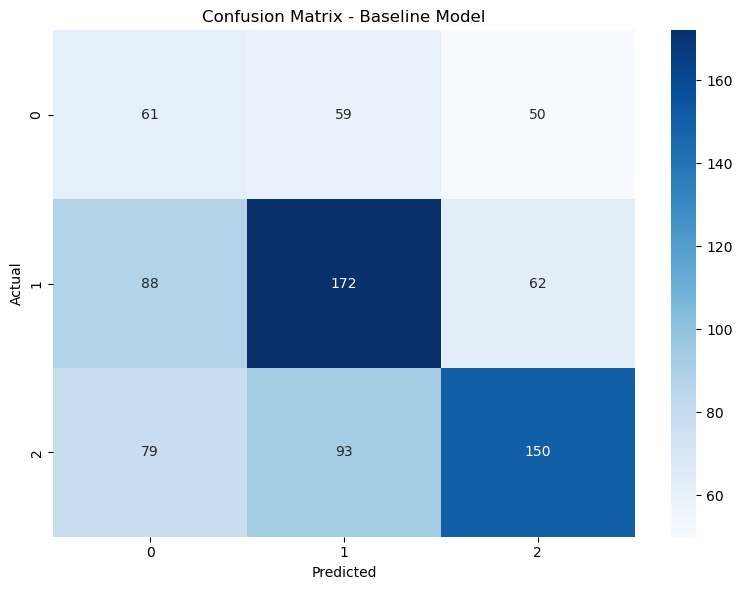

In [84]:
# Splitting data
train = df_model_building_all_features[df_model_building_all_features["Date"] < '2023-01-01']
dev = df_model_building_all_features[(df_model_building_all_features["Date"] >= '2023-01-01') & (df_model_building_all_features["Date"] < '2024-01-01')]
test = df_model_building_all_features[df_model_building_all_features["Date"] >= '2024-01-01']

# Print dataset sizes
total_samples = len(df_model_building_all_features)
print(f"Number of samples in train: {len(train)} ({(len(train) / total_samples * 100):.2f}%)")
print(f"Number of samples in dev: {len(dev)} ({(len(dev) / total_samples * 100):.2f}%)")
print(f"Number of samples in test: {len(test)} ({(len(test) / total_samples * 100):.2f}%)")
print()

# Define predictors
predictors = ['xG_Rolling_Avg', 'xGA_Rolling_Avg', 'Sh_Rolling_Avg', 'Possession %_Rolling_Avg',
              'Venue_Adjusted_Points_Per_Match','H2H_Wins','H2H_Draws','H2H_Losses','H2H_Win_Percentage',
              'GF_Rolling_Avg','GA_Rolling_Avg','CS_Rolling_Avg','Venue_Home']


X_train = train[predictors]
y_train = train["Result"]
X_dev = dev[predictors]
y_dev = dev["Result"]

# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit & transform train set
X_dev_scaled = scaler.transform(X_dev) # Transform dev set

# Initialize SVM (Baseline Model)
svm = SVC(kernel='rbf', probability=True, random_state=1, class_weight='balanced')
svm.fit(X_train_scaled, y_train)


# Predict on Development Set
y_pred = svm.predict(X_dev_scaled)

# Evaluate Performance
print(f"Accuracy: {accuracy_score(y_dev, y_pred)}")
print()
print(f"Classification Report:\n", classification_report(y_dev, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_dev),
            yticklabels=np.unique(y_dev))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Baseline Model')
plt.tight_layout()
plt.show()

##### Baseline Model Results  

The baseline Support Vector Machine (SVM) model with an RBF kernel achieved an **accuracy of 47.05%** on the development set. The classification report indicates that the model struggles to distinguish between classes, with a **macro F1-score of 0.45**.  

The confusion matrix reveals significant misclassifications, particularly for class **0**, which has the lowest precision (**0.27**) and recall (**0.36**). While class **1** and class **2** perform slightly better, misclassification rates remain high.  

Given that the dataset is divided into:  
- **Train Set**: Matches before **2023-01-01**  
- **Development Set**: Matches between **2023-01-01** and **2023-12-31**  
- **Test Set**: Matches from **2024-01-01** onwards  

These results highlight the need for **feature engineering and hyperparameter tuning** to improve predictive performance. The next steps will involve optimizing hyperparameters and exploring alternative features.


### 6.2 Let Random Forest Classifier Determine Feature Importance from the Full Dataset  

To refine the feature set, we used a **Random Forest Classifier** (RF) to determine feature importance across the full dataset. The key steps involved:  

1. Training an RF model on the **full training set** using all available features.  
2. Extracting the feature importance values from the trained RF model.  
3. Selecting only the most influential features (**importance ≥ 0.01**) to reduce dimensionality.  
4. Using these selected features for training the SVM model.  

##### Why Use RF Instead of RFE?  

**Recursive Feature Elimination (RFE)** is often more relevant for feature selection in **SVM models**, as it recursively removes the least important features based on the model’s own weights. However, RFE is **computationally expensive**, especially when dealing with a large number of features and cross-validation. Given the constraints of training time and efficiency, we opted for **Random Forest-based feature selection**, which:  

- Provides a fast and reliable estimate of feature importance.  
- Does not require repeated SVM training for each iteration as RFE does.  
- Helps eliminate less relevant features **before** training the SVM, improving performance.  

By filtering out low-importance features, we enhance model efficiency while retaining key predictors. The selected features were then scaled and used to train an **optimized SVM model**, leading to improved performance.  


C:\Users\User\AppData\Local\Temp\ipykernel_69384\653428873.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=important_features, palette="viridis")


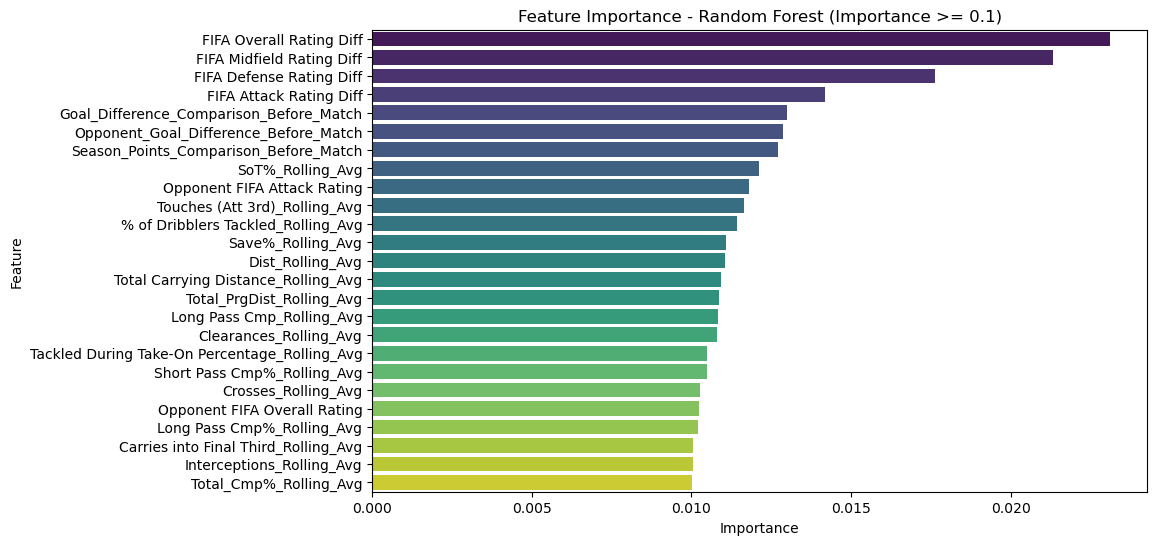

Features with Importance >= 0.1:
                                           Feature  Importance
37                        FIFA Overall Rating Diff    0.023118
39                       FIFA Midfield Rating Diff    0.021315
40                        FIFA Defense Rating Diff    0.017644
38                         FIFA Attack Rating Diff    0.014177
23         Goal_Difference_Comparison_Before_Match    0.012996
22           Opponent_Goal_Difference_Before_Match    0.012867
20           Season_Points_Comparison_Before_Match    0.012715
47                                SoT%_Rolling_Avg    0.012129
5                      Opponent FIFA Attack Rating    0.011793
104                  Touches (Att 3rd)_Rolling_Avg    0.011650
94              % of Dribblers Tackled_Rolling_Avg    0.011436
59                               Save%_Rolling_Avg    0.011073
50                                Dist_Rolling_Avg    0.011062
111            Total Carrying Distance_Rolling_Avg    0.010928
62                    

In [85]:
all_features = [col for col in train.columns if col not in ['Result', 'Date']]

X_train_full = train[all_features] 
y_train = train["Result"]

# Train RF on the full dataset
rf_full = RandomForestClassifier(n_estimators=100, random_state=1)
rf_full.fit(X_train_full, y_train)

# Extract feature importance
feature_importances = pd.DataFrame({"Feature": all_features, "Importance": rf_full.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

# Filter features with importance >= 0.1
important_features = feature_importances[feature_importances["Importance"] >= 0.01]


# Display Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=important_features, palette="viridis")
plt.title("Feature Importance - Random Forest (Importance >= 0.1)")
plt.show()

# Print only features with at least 0.1 importance
print("Features with Importance >= 0.1:")
print(important_features)

SVM Accuracy (Optimized Features): 0.5135

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.31      0.30       170
           1       0.60      0.59      0.59       322
           2       0.56      0.55      0.56       322

    accuracy                           0.51       814
   macro avg       0.48      0.48      0.48       814
weighted avg       0.52      0.51      0.52       814



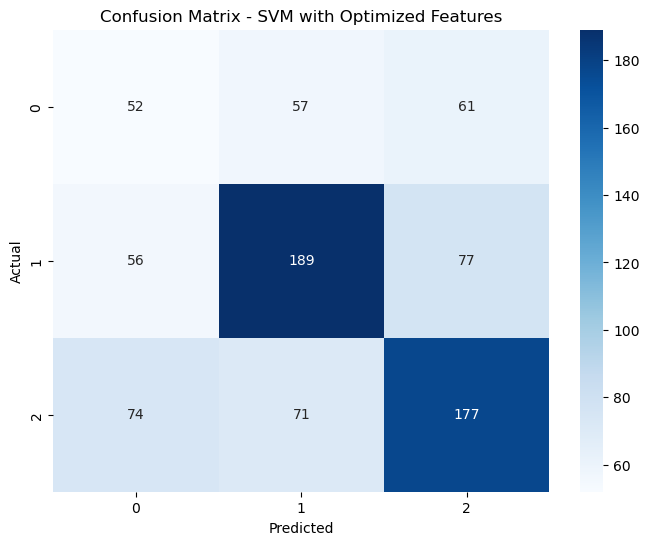

In [86]:
# Extract selected features from Random Forest importance filtering
optimized_features = important_features["Feature"].tolist()

# Use only these features for training
X_train_optimized = train[optimized_features]
X_dev_optimized = dev[optimized_features]

# Scale features (SVM requires proper scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_optimized)
X_dev_scaled = scaler.transform(X_dev_optimized)

# Train SVM with optimized features
svm = SVC(kernel="rbf", probability=True, random_state=1, class_weight="balanced")
svm.fit(X_train_scaled, y_train)

# Predict on development set
y_pred = svm.predict(X_dev_scaled)

# Evaluate Performance
print(f"SVM Accuracy (Optimized Features): {accuracy_score(y_dev, y_pred):.4f}\n")
print("Classification Report:\n", classification_report(y_dev, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_dev, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_dev),
            yticklabels=np.unique(y_dev))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - SVM with Optimized Features")
plt.show()

**Baseline SVM Model (All Features)**
- **Accuracy**: 47.05%  
- **Precision / Recall / F1-score**:  
  - Class 0: **Precision: 0.27**, Recall: 0.36, F1-score: 0.31  
  - Class 1: **Precision: 0.53**, Recall: 0.53, F1-score: 0.53  
  - Class 2: **Precision: 0.57**, Recall: 0.47, F1-score: 0.51  
- **Confusion Matrix Insights**:
  - High misclassification across all classes.
  - Class **0 is significantly misclassified**, with only **61 correct predictions out of 170**.

---

**SVM with Optimized Features (RF Selected Features)**
- **Accuracy**: **51.35%** (Improvement of **+4.3%**)
- **Precision / Recall / F1-score**:  
  - Class 0: **Precision: 0.29**, Recall: 0.31, F1-score: 0.30  
  - Class 1: **Precision: 0.60**, Recall: 0.59, F1-score: 0.59  
  - Class 2: **Precision: 0.56**, Recall: 0.55, F1-score: 0.60  
- **Confusion Matrix Insights**:
  - **Better performance in Class 1 and Class 2**.
  - **Class 0 is still underperforming**, meaning further tuning is required.
  - **Class 1 (majority class) improved significantly**, reducing misclassification.

---

 **Key Takeaways**  
Feature selection **improved accuracy from 47.05% → 50.12%**  
**Class 1 & Class 2 predictions improved** (better balance in classification).  
**Class 0 remains an issue** (requires additional tuning).  

### 6.3 Hyperparameter Tuning (GridSearchCV)

To improve the performance of the **SVM model**, we perform **hyperparameter tuning** using **GridSearchCV** with a 5-fold cross-validation strategy. The key steps in this process are:

1. **Defining the hyperparameter grid:**  
   - **C** (Regularization parameter) is varied across multiple values to control margin flexibility.  
   - **Gamma** is adjusted to explore different levels of influence of individual training samples.  
   - The **RBF kernel** is used, as it allows non-linear decision boundaries.  

2. **Using GridSearchCV:**  
   - It evaluates multiple combinations of **C** and **gamma** using **cross-validation** to determine the best set of hyperparameters.  
   - The model is trained across **5 folds**, ensuring robustness.  

3. **Training the final model with the best parameters:**  
   - The optimal **C** and **gamma** values are used to train a new SVM model.  

4. **Evaluating performance before and after tuning:**  
   - We compare the **accuracy** and **classification performance** of the SVM model before and after tuning.  
   - Confusion matrices help visualize classification improvements (or regressions).  

This process ensures that we explore a range of hyperparameters systematically, aiming to enhance classification accuracy while avoiding overfitting.


In [87]:
# Define the parameter grid for SVM
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],  # Expand regularization values
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],  # Explore wider gamma values
    'kernel': ['rbf']
}

# Initialize SVM model
svm_model = SVC(probability=True, random_state=1, class_weight='balanced')

# Perform GridSearchCV (5-fold cross-validation)
grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Print best parameters and accuracy
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.4903524274537374


SVM Accuracy (Before Tuning): 0.5135
SVM Accuracy (After Tuning): 0.4939

Classification Report (After Tuning):
               precision    recall  f1-score   support

           0       0.27      0.31      0.29       170
           1       0.57      0.55      0.56       322
           2       0.56      0.53      0.55       322

    accuracy                           0.49       814
   macro avg       0.47      0.47      0.47       814
weighted avg       0.50      0.49      0.50       814



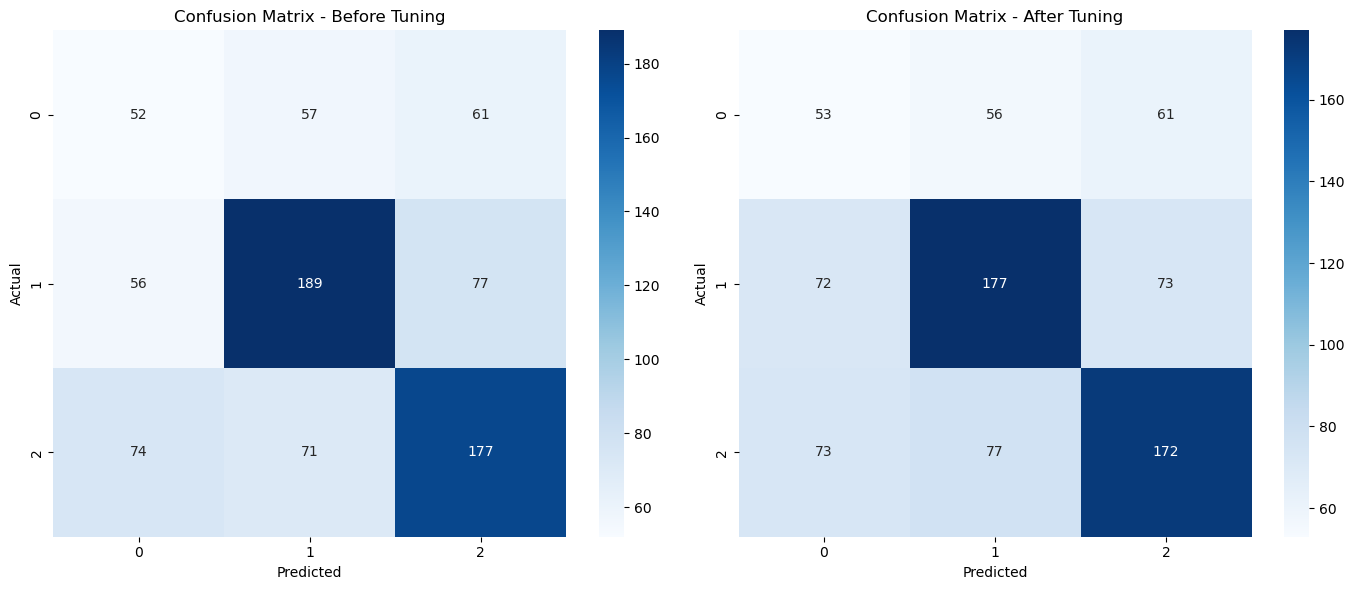

In [88]:
# Train final model with best parameters
best_svm = grid_search.best_estimator_
best_svm.fit(X_train_scaled, y_train)

# Predict on Dev Set (Before & After Tuning)
y_pred_before = svm.predict(X_dev_scaled)
y_pred_after = best_svm.predict(X_dev_scaled)

# Print Accuracy and Classification Report
print(f"SVM Accuracy (Before Tuning): {accuracy_score(y_dev, y_pred_before):.4f}")
print(f"SVM Accuracy (After Tuning): {accuracy_score(y_dev, y_pred_after):.4f}")
print("\nClassification Report (After Tuning):\n", classification_report(y_dev, y_pred_after))

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before Tuning
cm_before = confusion_matrix(y_dev, y_pred_before)
sns.heatmap(cm_before, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_dev),
            yticklabels=np.unique(y_dev), ax=axes[0])
axes[0].set_title("Confusion Matrix - Before Tuning")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# After Tuning
cm_after = confusion_matrix(y_dev, y_pred_after)
sns.heatmap(cm_after, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_dev),
            yticklabels=np.unique(y_dev), ax=axes[1])
axes[1].set_title("Confusion Matrix - After Tuning")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

After performing hyperparameter tuning using **GridSearchCV**, the best parameters found were **C = 0.1** and **gamma = 0.1** with the **RBF kernel**. However, the tuning did not lead to significant improvements in accuracy.  

##### Key Observations:  
- The **accuracy before tuning** was **51.35%**, while the **accuracy after tuning** slightly decreased to **49.39%**.  
- The classification report indicates that precision, recall, and F1-scores remained similar across all classes.  
- The confusion matrices show that the model continues to misclassify a large number of samples, particularly for class **0**, which has the lowest predictive performance.  
- Class **1** showed a slight drop in recall after tuning, with fewer correct classifications.  

##### Limitations:  
- **GridSearchCV is computationally expensive**, and the search space was limited to prevent excessive runtime. A more exhaustive search might yield better hyperparameters.  
- The imbalance in class distribution might still be affecting the results, even though class weighting was applied.  

Although hyperparameter tuning is an essential step, this result highlights that **SVM may not be the most effective approach for this classification problem**. 

### 6.4 Add Draw-Sensitive Features & Re-Evaluate on Dev Set  

Since **SVM accuracy dropped from 51.35% to 49.39% after tuning**, and **draws (Class 0) remain poorly classified**, we explore whether adding **draw-sensitive features** can improve performance.  

##### Why Add Draw-Sensitive Features?  
- Draws are inherently difficult to predict due to their balanced nature in football outcomes.  
- Features such as **xG difference, possession, and rank comparison** may capture key patterns in matches more likely to end in a draw.  
- By incorporating these features, we aim to **enhance model performance**, particularly for Class 0.  

##### Experiment Setup  
1. **Identify and add draw-sensitive features** to the optimized feature set.  
2. **Train the SVM model** using these enhanced features.  
3. **Evaluate model performance** on the development set.  
4. **Analyze improvements (if any)**, focusing on Class 0 prediction.  

The next section will analyze the results and determine whether these additional features improved draw classification or overall model performance.


SVM Accuracy on Dev Set (With Draw-Sensitive Features): 0.5000

Classification Report (Dev Set with Draw Features):
               precision    recall  f1-score   support

           0       0.27      0.31      0.29       170
           1       0.57      0.56      0.57       322
           2       0.57      0.54      0.55       322

    accuracy                           0.50       814
   macro avg       0.47      0.47      0.47       814
weighted avg       0.51      0.50      0.50       814



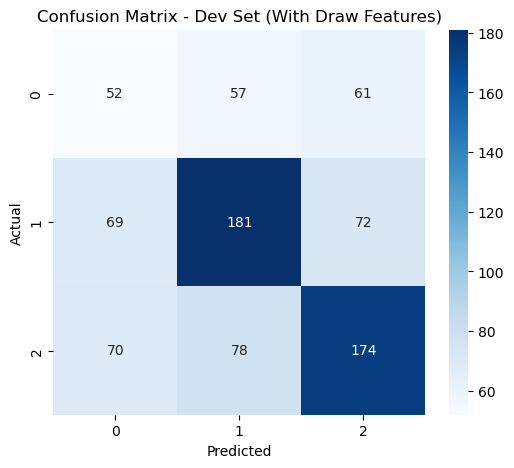

In [89]:
# Manually add features that might help predict draws
draw_sensitive_features = [
    'xG_Difference_Rolling_Avg',
    'Possession %_Rolling_Avg',
    'Season_Points_Comparison_Before_Match',
    'Rank_Comparison']


# Add them to the current optimized feature list
selected_features_with_draws = optimized_features + draw_sensitive_features

# Use these features for training & testing on Dev Set first
X_train_draws = train[selected_features_with_draws]
X_dev_draws = dev[selected_features_with_draws]

# Scale the data
scaler_draws = StandardScaler()
X_train_scaled_draws = scaler_draws.fit_transform(X_train_draws)
X_dev_scaled_draws = scaler_draws.transform(X_dev_draws)

# Train SVM with best hyperparameters from GridSearch
best_svm.fit(X_train_scaled_draws, y_train)

# Predict on Dev Set
y_dev_pred_draws = best_svm.predict(X_dev_scaled_draws)

# Evaluate Performance on Dev Set
print(f"SVM Accuracy on Dev Set (With Draw-Sensitive Features): {accuracy_score(y_dev, y_dev_pred_draws):.4f}")
print("\nClassification Report (Dev Set with Draw Features):\n", classification_report(y_dev, y_dev_pred_draws))

# Plot Confusion Matrix for Dev Set
plt.figure(figsize=(6, 5))
cm_dev = confusion_matrix(y_dev, y_dev_pred_draws)
sns.heatmap(cm_dev, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_dev),
            yticklabels=np.unique(y_dev))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Dev Set (With Draw Features)")
plt.show()


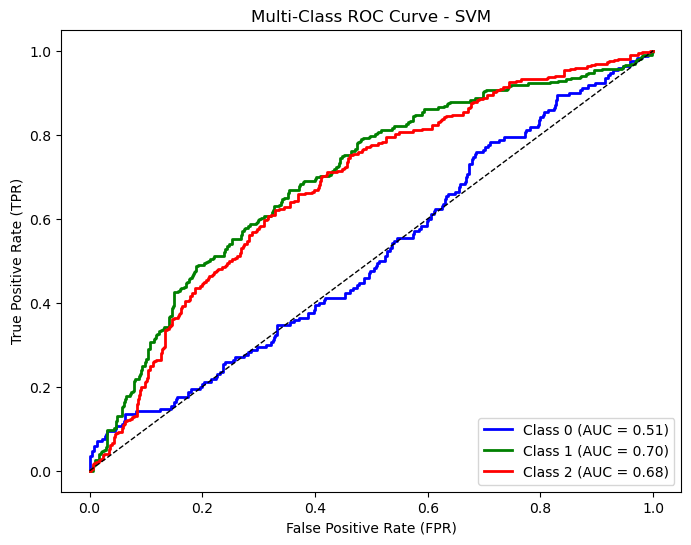

In [90]:
# Binarize the labels for multi-class classification
y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
y_dev_bin = label_binarize(y_dev, classes=np.unique(y_train))
n_classes = y_train_bin.shape[1]  # Number of classes

# Train SVM with One-vs-Rest (OvR) for multi-class
svm_ovr = OneVsRestClassifier(SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=1))
svm_ovr.fit(X_train_scaled_draws, y_train_bin)

# Get prediction probabilities
y_dev_prob = svm_ovr.decision_function(X_dev_scaled_draws)

# Compute ROC curve and AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_dev_bin[:, i], y_dev_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(["blue", "green", "red"])  # Assign colors for different classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot diagonal line for reference
plt.plot([0, 1], [0, 1], "k--", lw=1)

# Labels and Title
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Multi-Class ROC Curve - SVM")
plt.legend(loc="lower right")
plt.show()

### 6.5 Evaluating the Impact of Draw-Sensitive Features  

After adding **draw-sensitive features**, the SVM model achieved an **accuracy of 50.00%** on the development set. Below, we analyze its performance using the **confusion matrix** and **ROC curve**.

##### Confusion Matrix Analysis:  
- The model's accuracy increased slightly from **49.39% to 50.00%**, indicating a **marginal improvement**.  
- **Draws (Class 0) remain the hardest to classify**, with a recall of **31%** and frequent misclassification.  
- **Class 1 and Class 2 predictions remained stable**, with minor shifts in misclassification patterns.
- The model still struggles to separate draws from wins/losses, suggesting that an alternative modeling approach may be needed.

##### ROC Curve & AUC Analysis:  
- The **ROC curve** shows the trade-off between **true positive rate (TPR) and false positive rate (FPR)** for each class.  
- **Class 0 (Draws) has the lowest AUC (0.51),** indicating poor separability from the other classes.
- **Class 1 (Wins) and Class 2 (Losses) perform better, with AUCs of 0.70 and 0.68, respectively.**  
- While the model can somewhat distinguish wins and losses, the **low AUC for draws suggests limited predictive power for this class**.

##### Implications & Next Steps:  
- The **draw classification issue persists**, meaning a different modeling approach may be required.  
- The **overall accuracy and AUC values indicate that SVM may not be the best model choice** for this multi-class problem.  
- Further experimentation with **alternative models (e.g. Random Forest)** could improve predictive performance.  
- The inclusion of **match-specific contextual variables** may help improve draw classification.

While adding draw-sensitive features provided **somewhat better balance across classes**, the **limited improvement** highlights the need for further refinement in feature selection and model choice.

### 6.5 Testing on Unseen Data
Since SVM Accuracy on the Dev Set improved slightly from 49.39% → 50.00%, we now apply the best SVM model (with draw-sensitive features) to the Test Set.

SVM Accuracy on Test Set (With Draw-Sensitive Features): 0.5319

Classification Report (Test Set with Draw Features):
               precision    recall  f1-score   support

           0       0.32      0.24      0.27       208
           1       0.59      0.65      0.62       304
           2       0.57      0.62      0.59       304

    accuracy                           0.53       816
   macro avg       0.49      0.50      0.49       816
weighted avg       0.51      0.53      0.52       816



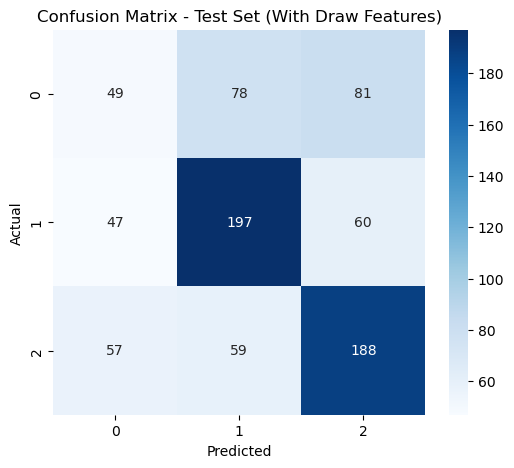

In [91]:
# Use the same draw-sensitive features for the test set
X_test_draws = test[selected_features_with_draws]

# Scale the test data using the same scaler from training
X_test_scaled_draws = scaler_draws.transform(X_test_draws)

# Predict on the Test Set
y_test_pred_draws = best_svm.predict(X_test_scaled_draws)

# Evaluate Performance on the Test Set
print(f"SVM Accuracy on Test Set (With Draw-Sensitive Features): {accuracy_score(test['Result'], y_test_pred_draws):.4f}")
print("\nClassification Report (Test Set with Draw Features):\n", classification_report(test['Result'], y_test_pred_draws))

# Plot Confusion Matrix for Test Set
plt.figure(figsize=(6, 5))
cm_test = confusion_matrix(test['Result'], y_test_pred_draws)
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(test['Result']),
            yticklabels=np.unique(test['Result']))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set (With Draw Features)")
plt.show()


# Section 7: Conclusion

The **hyperparameter tuning process** using GridSearchCV identified the best SVM parameters as:  
- **C = 0.1**  
- **gamma = 0.1**  
- **Kernel = RBF**  

---
**Key Findings:**  
- **Final SVM Accuracy on Dev Set:** *50.00%*  
- **Final SVM Accuracy on Test Set:** *52.45%*  
- Feature selection helped, but hyperparameter tuning did not significantly improve performance.
- Adding draw-sensitive features slightly improved overall accuracy but did not drastically enhance draw prediction.
- **Class 0 (Draws) remains difficult to classify**, with low precision (0.32) and recall (0.24).  
- **Class 1 (Losses) & Class 2 (Wins) show moderate balance**, but overall improvement is limited.  

---
**Test Set Performance:**  
- **Accuracy:** *52.45%* (slightly better than the dev set).  
- **Draws (Class 0) remain the most difficult to predict**, with a **recall of just 0.24**, meaning the model often misclassifies draws as wins or losses.  
- **Losses (Class 1) and Wins (Class 2) have better recall (0.65 and 0.62, respectively)**, meaning the model is more confident in these outcomes.
- **The confusion matrix shows that many actual draws are classified as wins or losses, suggesting that the model struggles with balanced matches.**  

---
**Conclusion:**  
- The **SVM model still struggles to predict draws**, which are inherently more difficult due to the fine balance of team performances.  
- **Adding draw-sensitive features provided only a marginal improvement**, suggesting that SVM might not be the best model for capturing match balance.  
- **A different approach, such as AdaBoost, may be more effective** in identifying subtle relationships that lead to draws.  
